# 배달 주문건수 데이터 EDA
날씨, 미세먼지, 축구경기, 구별 인구수 데이터를 크롤링하고 주말, 공휴일, 요일 데이터를 추가한다.

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
plt.rc('font', family='NanumBarunGothic') 
from category_encoders import OneHotEncoder,OrdinalEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import json
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

In [2]:
DATA_PATH = ''

df_19 = pd.read_csv(f'{DATA_PATH}delivery_2019.csv', names = ['날짜', '시간', '업종', '시도', '구', '주문건수'])
df_20 = pd.read_csv(f'{DATA_PATH}delivery_2020.csv', names = ['날짜', '시간', '업종', '시도', '구', '주문건수'])
df_21 = pd.read_csv(f'{DATA_PATH}delivery_2021.csv')
df_21 = df_21.rename(columns = {'date' : '날짜', 'hour' : '시간', 'category' : '업종', 'sido': '시도', 'gu' : '구', 'order' : '주문건수' })

In [3]:
display(df_19.head())
display(df_20.head())
display(df_21.head())

,날짜,시간,업종,시도,구,주문건수
0,2019-05-01,0,족발/보쌈,충청북도,제천시,2
1,2019-05-01,0,치킨,충청북도,제천시,5
2,2019-05-01,1,치킨,충청북도,제천시,6
3,2019-05-01,10,패스트푸드,충청북도,제천시,1
4,2019-05-01,10,한식,충청북도,제천시,4


,날짜,시간,업종,시도,구,주문건수
0,2020-01-01,0,돈까스/일식,경기도,고양시 덕양구,2
1,2020-01-01,0,돈까스/일식,경기도,광명시,6
2,2020-01-01,0,돈까스/일식,경기도,부천시,3
3,2020-01-01,0,돈까스/일식,경기도,의정부시,7
4,2020-01-01,0,돈까스/일식,전라북도,군산시,5


,날짜,시간,업종,시도,구,주문건수
0,2021-01-01,0,돈까스/일식,경기도,동두천시,3
1,2021-01-01,0,돈까스/일식,경기도,부천시,49
2,2021-01-01,0,돈까스/일식,경기도,안산시 상록구,5
3,2021-01-01,0,돈까스/일식,경기도,의정부시,6
4,2021-01-01,0,돈까스/일식,경상남도,진주시,3


In [4]:
print(df_19['날짜'].nunique())
print(df_20['날짜'].nunique())
print(df_21['날짜'].nunique())

245
365
205


In [5]:
display(df_19.tail()) #빠진날도 있지만 12월 31일까지 다 있다.
display(df_20.tail()) # 1월부터 12월 31일 까지 다 있다.
display(df_21.tail()) # 7월 까지밖에 없다.

,날짜,시간,업종,시도,구,주문건수
753355,2019-12-31,23,회,서울특별시,도봉구,2
753356,2019-12-31,23,회,서울특별시,영등포구,1
753357,2019-12-31,23,회,서울특별시,은평구,9
753358,2019-12-31,23,회,제주특별자치도,서귀포시,1
753359,2019-12-31,23,회,충청남도,서산시,1


,날짜,시간,업종,시도,구,주문건수
2015376,2020-12-31,23,회,서울특별시,양천구,1
2015377,2020-12-31,23,회,서울특별시,은평구,5
2015378,2020-12-31,23,회,전라남도,광양시,3
2015379,2020-12-31,23,회,충청남도,서산시,1
2015380,2020-12-31,23,회,충청남도,천안시 서북구,1


,날짜,시간,업종,시도,구,주문건수
1026041,2021-07-31,23,한식,제주특별자치도,서귀포시,1
1026042,2021-07-31,23,한식,충청남도,천안시 서북구,2
1026043,2021-07-31,23,회,경기도,이천시,2
1026044,2021-07-31,23,회,전라남도,광양시,2
1026045,2021-07-31,23,회,충청남도,천안시 서북구,1


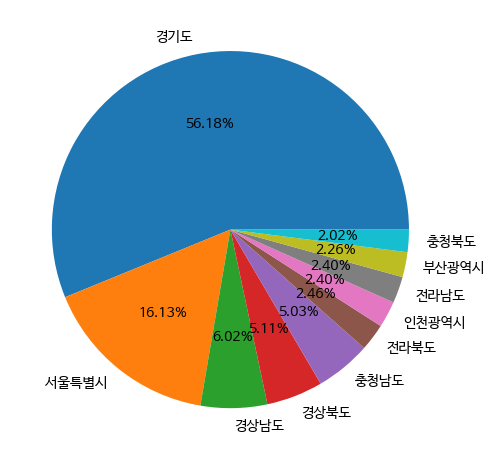

In [31]:
# 도별 주문건수 그래프
df_all = pd.concat([df_19,df_20,df_21], axis = 0)
df_pie = (df_all.groupby(['시도'])['주문건수'].sum().sort_values(ascending = False).to_frame() / sum(df_all['주문건수'])) * 100
fig = plt.figure(figsize = (8,15))
plt.pie(df_pie['주문건수'].iloc[:10], labels = df_pie.index[:10], autopct = '%.2f%%',textprops={'fontsize': 14})
plt.show()

### 그래프 보면 경기도가 젤 주문량이 많은데 서울과는 달리 도 단위니까 당연히 서울보다 많을 것이다.
### 하지만 서울은 시단윈데 두번째로 주문량이 많다.

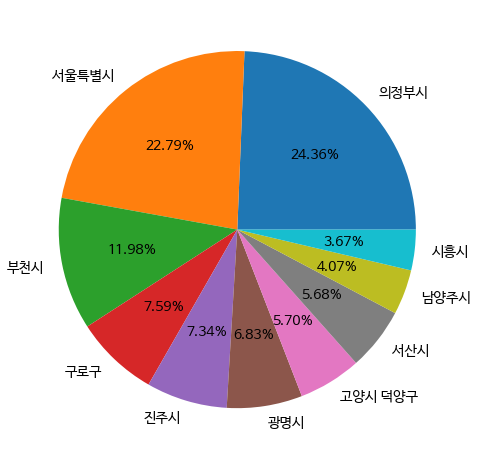

In [32]:
#시별 주문건수 그래프
df_gu = df_all.groupby(['구'])['주문건수'].sum()
df_seoul = df_all.loc[df_all['시도'] == '서울특별시'].groupby('시도')['주문건수'].sum()
df_pie2 = pd.concat([df_gu, df_seoul], axis = 0).sort_values(ascending = False)
fig = plt.figure(figsize = (8,15))
plt.pie(df_pie2.iloc[:10], labels = df_pie2.index[:10], autopct = '%.2f%%',textprops={'fontsize': 14})
plt.show()

서울을 시단위랑 비교하면 의정부시 다음으로 주문량이 많다.
가장 배달이 활발한 의정부시를 사용하면 좋겠지만, 의정부시는 주어진 데이터에서 동 단위로 세분화 되어 있지 않아서 더 정확하고, 세분화된 인사이트 도출을 위해 데이터에 구별로 세분화 되어 있는 서울 특별시에 대해 분석해보자.

In [33]:
# 서울특별시인 데이터만 추출
df_all = df_all.loc[df_all['시도'] == '서울특별시']
display(df_all.head())

print(df_all.isnull().sum())
print(df_all.duplicated().sum())

,날짜,시간,업종,시도,구,주문건수
1780,2019-05-19,14,치킨,서울특별시,중구,1
2072,2019-05-21,16,한식,서울특별시,도봉구,1
2601,2019-05-24,12,치킨,서울특별시,도봉구,1
3603,2019-05-27,23,치킨,서울특별시,중구,1
3888,2019-05-29,16,치킨,서울특별시,도봉구,1


날짜      0
시간      0
업종      0
시도      0
구       0
주문건수    0
dtype: int64
0


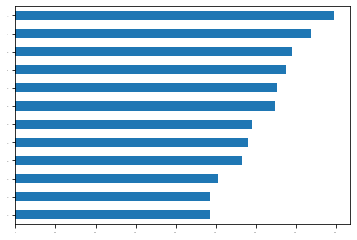

In [34]:
#월별 데이터수
df_all['월'] = df_all['날짜'].str.split('-').apply(lambda x: x[1])
df_all.drop(columns = ['날짜', '시도'], inplace = True)
df_all['월'].value_counts().sort_values(ascending = True).plot.barh() # 데이터들이 엄청 불균형한 정도는 아니다.

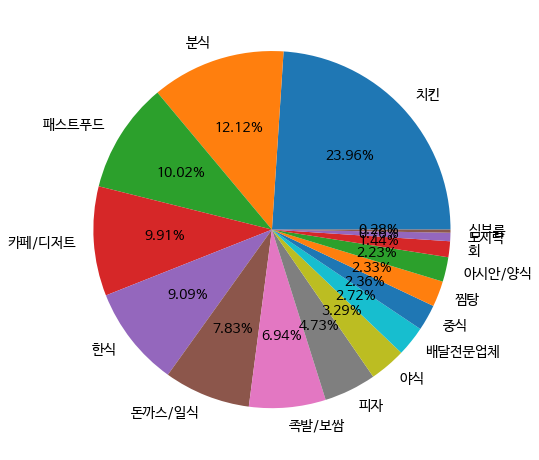

In [35]:
#업종별 데이터수
df_pie = pd.DataFrame((df_all.groupby('업종')['주문건수'].sum().sort_values(ascending = False) / sum(df_all['주문건수'])) * 100)
df_pie
fig = plt.figure(figsize = (8,15))
plt.pie(df_pie['주문건수'], labels = df_pie.index, autopct = '%.2f%%', textprops={'fontsize': 14})
plt.show()

역시나 치킨이 젤 많다. 도시락과 심부름은 주문 건수가 1프로 미만이다. 별로 중요하지 않으므로 제거

In [36]:
df_all = df_all.loc[~df_all['업종'].isin(['도시락', '심부름'])]
df_all['업종'].unique()

array(['치킨', '한식', '카페/디저트', '분식', '패스트푸드', '피자', '족발/보쌈', '찜탕', '중식',
       '돈까스/일식', '회', '야식', '아시안/양식', '배달전문업체'], dtype=object)

In [37]:
df_all['주문건수'].value_counts() #시간대별이니까 주문건수가 1,2인 경우가 엄청 많다.

1      231953
2      124825
3       78003
4       54965
5       39807
        ...  
151         1
146         1
145         1
141         1
254         1
Name: 주문건수, Length: 173, dtype: int64

서울특별시에서 구별로 주문건수를 정확히 예측하는 것보다 주문이 얼마나 될 것인지의 정도를 예측하는 것이 더 좋은 분석이 될 것 같다.

EX) 내일 마포구에서 100건 정도의 주문이 발생할거야! -> 100건이 많은 건가???

내일 마포구는 주문이 많이 들어올거야! -> 내일 많이 팔리는구나!

In [38]:
df_all['주문건수'].quantile([0.35,0.65,0.85,0.95]) #2건까지 주문 적음(1), 4건까지 주문 보통(2), 5건부터 주문 많음으로 하자(3).

0.35     2.0
0.65     4.0
0.85     9.0
0.95    18.0
Name: 주문건수, dtype: float64

In [39]:
df_all.loc[df_all['주문건수'] <= 2, '주문정도'] = 1
df_all.loc[(df_all['주문건수'] > 2) & (df_all['주문건수'] <= 4), '주문정도'] = 2
df_all.loc[df_all['주문건수'] > 4, '주문정도'] = 3
display(df_all.head())
df_all.isnull().sum().sum()

,시간,업종,구,주문건수,월,주문정도
1780,14,치킨,중구,1,05,1.0
2072,16,한식,도봉구,1,05,1.0
2601,12,치킨,도봉구,1,05,1.0
3603,23,치킨,중구,1,05,1.0
3888,16,치킨,도봉구,1,05,1.0


0

In [40]:
df_all['주문정도'] = df_all['주문정도'].astype(int)
df_all['주문정도'].value_counts(normalize = True) #class가 엄청 불균형 하지는 않은 것 같다.

1    0.494538
3    0.321152
2    0.184310
Name: 주문정도, dtype: float64

In [41]:
#data leak을 피하기 위해 주문 건수는 제거
df_all.drop(columns = ['주문건수'],inplace = True)
X_train, X_test = train_test_split(df_all, test_size = 0.2, random_state = 42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state = 42)
y_train, y_val, y_test = X_train.pop('주문정도'), X_val.pop('주문정도'), X_test.pop('주문정도')
display(X_train.head())
display(X_val.head())
display(y_train.head())

,시간,업종,구,월
256661,13,중식,영등포구,02
116383,11,분식,양천구,01
247051,17,분식,양천구,02
135370,14,분식,영등포구,01
1004541,15,치킨,서초구,07


,시간,업종,구,월
715431,20,한식,양천구,05
332825,17,야식,노원구,10
366170,16,족발/보쌈,도봉구,02
543895,6,패스트푸드,서초구,04
1718677,21,야식,동작구,11


256661     3
116383     1
247051     1
135370     1
1004541    2
Name: 주문정도, dtype: int64

In [42]:
# baseline 모델 = 최빈값
print(y_train.value_counts(normalize = True))
y_pred = [1] * len(y_train)
accuracy_score(y_train, y_pred) # 정확도가 절반이 안 된다.
#이것보다는 좋은 모델을 만들어야함.

1    0.494413
3    0.321247
2    0.184339
Name: 주문정도, dtype: float64


0.49441326867640273

In [49]:
#파이프를 넣으면 정확도와 AUC를 계산하는 함수
def accuracy_and_auc(pipe):
    print('학습 정확도', pipe.score(X_train, y_train))
    print('검증 정확도', pipe.score(X_val, y_val))
    y_prob = pipe.predict_proba(X_train)
    print('학습 AUC',roc_auc_score(y_train, y_prob, multi_class="ovr", average="weighted"))

    y_prob = pipe.predict_proba(X_val)
    print('검증 AUC', roc_auc_score(y_val, y_prob, multi_class="ovr", average="weighted"))
    

### 간단하게 Logistic Regression을 돌려보자. 다중분류회귀 모델(주문 정도 3, 2, 1)

In [50]:
pipe_glm = make_pipeline(OneHotEncoder(use_cat_names = True),
                       LogisticRegression(solver='liblinear', multi_class='auto', C=100.0, random_state=42))  
# C는 규제. Ridge와 다르게 작을수록 규제가 큰 것. 과적합 방지

pipe_glm.fit(X_train, y_train)

#과적합은 없지만 정확도는 별로 높지 않다.
accuracy_and_auc(pipe_glm)

학습 정확도 0.5863934557598885
검증 정확도 0.5866239279216842
학습 AUC 0.7097573829691752
검증 AUC 0.7115801526465535


### 변수들을 추가해서 성능을 높여보자.

### 1. 날씨 추가

In [59]:
df_all = pd.concat([df_19,df_20,df_21], axis = 0)
df_all = df_all.loc[df_all['시도'] == '서울특별시']
df_all['월'] = df_all['날짜'].str.split('-').apply(lambda x: x[1])
df_all = df_all.loc[~df_all['업종'].isin(['도시락', '심부름'])]
df_all.loc[df_all['주문건수'] <= 2, '주문정도'] = 1
df_all.loc[(df_all['주문건수'] > 2) & (df_all['주문건수'] <= 4), '주문정도'] = 2
df_all.loc[df_all['주문건수'] > 4, '주문정도'] = 3
display(df_all.head())
df_all['주문정도'] = df_all['주문정도'].astype(int)

,날짜,시간,업종,시도,구,주문건수,월,주문정도
1780,2019-05-19,14,치킨,서울특별시,중구,1,05,1.0
2072,2019-05-21,16,한식,서울특별시,도봉구,1,05,1.0
2601,2019-05-24,12,치킨,서울특별시,도봉구,1,05,1.0
3603,2019-05-27,23,치킨,서울특별시,중구,1,05,1.0
3888,2019-05-29,16,치킨,서울특별시,도봉구,1,05,1.0


In [60]:
df_all['시간'] = df_all['시간'].apply(lambda x: str('0' + f'{x}') if (x < 10) else str(x) )
df_all['시간'].unique()

array(['14', '16', '12', '23', '13', '17', '18', '20', '15', '21', '10',
       '19', '22', '11', '01', '02', '00', '09', '07', '03', '08', '04',
       '05', '06'], dtype=object)

In [61]:
df_all['time'] = (df_all['날짜'] + '-' + df_all['시간']).str.replace('-','.')
print(df_all.time.apply(len).unique()) #자릿수가 모두 맞춰졌다.
df_all.head()

[13]


,날짜,시간,업종,시도,구,주문건수,월,주문정도,time
1780,2019-05-19,14,치킨,서울특별시,중구,1,05,1,2019.05.19.14
2072,2019-05-21,16,한식,서울특별시,도봉구,1,05,1,2019.05.21.16
2601,2019-05-24,12,치킨,서울특별시,도봉구,1,05,1,2019.05.24.12
3603,2019-05-27,23,치킨,서울특별시,중구,1,05,1,2019.05.27.23
3888,2019-05-29,16,치킨,서울특별시,도봉구,1,05,1,2019.05.29.16


In [ ]:
def get_weather(time):
    time_url = f'&tm={time}%3A00'
    html = requests.get(url+time_url).text
    soup = BeautifulSoup(html, "html.parser")
    table = soup('table', 'table-col')[0]

    #테이블 내 모든 <tr> 태그
    table_rows = table.find_all('tr')
    #최초 두 태그는 테이블 헤더, 나머지가 데이터
    if len(table_rows) > 6: #날씨 정보가 있는 날
        table_headers = table_rows[:2]
        table_data = [table_rows[5]]
        table_data_elements = [x.find_all('td') for x in table_data]
    else:
        table_data_elements = [''] # 날씨 정보가 없는 날도 있음

    #모든 데이터 행에 대해 <td> 항목 추출
    data = []
    
    for elem in table_data_elements:
        if len(elem) == 14:
            elem = [elem[0],elem[5], elem[7],elem[8], elem[9],elem[10],elem[12]]
            data.append([x.text if idx != 6 else x.text.split('(')[1].split(',')[0].replace('\'','') for idx, x in enumerate(elem)])
        elif len(elem) == 13: #여름에는 적설량 변수가 없어서 index를 좀 바꿔서 해야함.
            elem = [elem[0],elem[5], elem[7],elem[8], elem[9],elem[11]]
            data.append([x.text if idx != 5 else x.text.split('(')[1].split(',')[0].replace('\'','') for idx, x in enumerate(elem)])
        else:
            data.append([np.nan] * 7)
    data[0].insert(0,time)
    if len(data[0]) == 7:
        data[0].insert(6,np.nan)
    data = pd.DataFrame(data, columns = ['time', '지점', '기온', '체감온도', '일강수량', '상대습도', '적설', '풍속'])
    df = pd.concat([df_weather, pd.DataFrame(data)],axis = 0)
    return df


In [ ]:
url = 'https://www.weather.go.kr/w/obs-climate/land/city-obs.do?auto_man=m&stn=0&dtm=&type=t99&reg=109'
df_weather = pd.DataFrame(columns = ['time', '지점', '기온', '체감온도','일강수량', '상대습도', '적설', '풍속'] )
for time in tqdm(df_all['time'].unique()):
    df_weather = get_weather(time)

In [74]:
df_weather.head()

,time,지점,기온,체감온도,일강수량,상대습도,적설,풍속
0,2019.05.19.14,서울,21.0,24.1,12.8,91.0,0.0,1.5
1,2019.05.21.16,서울,22.8,21.3,0.0,30.0,0.0,4.5
2,2019.05.24.12,서울,28.8,27.1,0.0,33.0,0.0,1.3
3,2019.05.27.23,서울,15.3,16.5,7.1,62.0,0.0,3.5
4,2019.05.29.16,서울,26.3,24.2,0.0,28.0,0.0,4.3


In [75]:
df_weather.loc[df_weather['적설'].isnull(),'적설'] = 0
df_weather.loc[df_weather['일강수량'] == '\xa0','일강수량'] = 0
df_weather.loc[df_weather['상대습도'] == '\xa0','상대습도'] = 0
df_weather.loc[df_weather['체감온도'] == '\xa0','체감온도'] = 0
df_weather.loc[df_weather['풍속'] == '&amp;nbsp;','풍속'] = 0

df_weather['년'] = df_weather['time'].str.split('.').apply(lambda x: x[0])
df_weather['월'] = df_weather['time'].str.split('.').apply(lambda x: x[1])
df_weather.head()

,time,지점,기온,체감온도,일강수량,상대습도,적설,풍속,년,월
0,2019.05.19.14,서울,21.0,24.1,12.8,91.0,0.0,1.5,2019,05
1,2019.05.21.16,서울,22.8,21.3,0.0,30.0,0.0,4.5,2019,05
2,2019.05.24.12,서울,28.8,27.1,0.0,33.0,0.0,1.3,2019,05
3,2019.05.27.23,서울,15.3,16.5,7.1,62.0,0.0,3.5,2019,05
4,2019.05.29.16,서울,26.3,24.2,0.0,28.0,0.0,4.3,2019,05


In [76]:
#NA인 부분을 각 년도별 계절 평균으로 모든 값을 대체하자.
df_weather[['체감온도', '일강수량', '상대습도', '풍속']] = df_weather[['체감온도', '일강수량', '상대습도', '풍속']].astype(float)
df_mean = df_weather.groupby(['년','월'])[['기온', '체감온도','일강수량','상대습도','풍속']].mean().reset_index()
df_mean = df_weather.merge(df_mean, on = ['년', '월'])
df_mean.head()

,time,지점,기온_x,체감온도_x,일강수량_x,상대습도_x,적설,풍속_x,년,월,기온_y,체감온도_y,일강수량_y,상대습도_y,풍속_y
0,2019.05.19.14,서울,21.0,24.1,12.8,91.0,0.0,1.5,2019,05,22.023077,21.807692,1.530769,46.153846,3.246154
1,2019.05.21.16,서울,22.8,21.3,0.0,30.0,0.0,4.5,2019,05,22.023077,21.807692,1.530769,46.153846,3.246154
2,2019.05.24.12,서울,28.8,27.1,0.0,33.0,0.0,1.3,2019,05,22.023077,21.807692,1.530769,46.153846,3.246154
3,2019.05.27.23,서울,15.3,16.5,7.1,62.0,0.0,3.5,2019,05,22.023077,21.807692,1.530769,46.153846,3.246154
4,2019.05.29.16,서울,26.3,24.2,0.0,28.0,0.0,4.3,2019,05,22.023077,21.807692,1.530769,46.153846,3.246154


In [77]:
df_mean.loc[df_mean['지점'].isnull(), '지점'] = '서울'
col1 = ['기온_x', '체감온도_x', '일강수량_x', '상대습도_x', '풍속_x']
col2 = ['기온_y', '체감온도_y', '일강수량_y', '상대습도_y', '풍속_y']
for i in range(len(col1)):
    df_mean.loc[df_mean[col1[i]].isnull(), col1[i]] = df_mean.loc[df_mean[col1[i]].isnull(), col2[i]]
print(df_mean.isnull().sum())
df_mean.head()

time      0
지점        0
기온_x      0
체감온도_x    0
일강수량_x    0
상대습도_x    0
적설        0
풍속_x      0
년         0
월         0
기온_y      0
체감온도_y    0
일강수량_y    0
상대습도_y    0
풍속_y      0
dtype: int64


,time,지점,기온_x,체감온도_x,일강수량_x,상대습도_x,적설,풍속_x,년,월,기온_y,체감온도_y,일강수량_y,상대습도_y,풍속_y
0,2019.05.19.14,서울,21.0,24.1,12.8,91.0,0.0,1.5,2019,05,22.023077,21.807692,1.530769,46.153846,3.246154
1,2019.05.21.16,서울,22.8,21.3,0.0,30.0,0.0,4.5,2019,05,22.023077,21.807692,1.530769,46.153846,3.246154
2,2019.05.24.12,서울,28.8,27.1,0.0,33.0,0.0,1.3,2019,05,22.023077,21.807692,1.530769,46.153846,3.246154
3,2019.05.27.23,서울,15.3,16.5,7.1,62.0,0.0,3.5,2019,05,22.023077,21.807692,1.530769,46.153846,3.246154
4,2019.05.29.16,서울,26.3,24.2,0.0,28.0,0.0,4.3,2019,05,22.023077,21.807692,1.530769,46.153846,3.246154


In [78]:
df_mean = df_mean[['time','지점','기온_x','체감온도_x','일강수량_x','상대습도_x','적설','풍속_x']]
df_mean.columns = df_weather.drop(columns = ['년','월']).columns                  
df_weather = df_mean.copy()
display(df_weather.head())

,time,지점,기온,체감온도,일강수량,상대습도,적설,풍속
0,2019.05.19.14,서울,21.0,24.1,12.8,91.0,0.0,1.5
1,2019.05.21.16,서울,22.8,21.3,0.0,30.0,0.0,4.5
2,2019.05.24.12,서울,28.8,27.1,0.0,33.0,0.0,1.3
3,2019.05.27.23,서울,15.3,16.5,7.1,62.0,0.0,3.5
4,2019.05.29.16,서울,26.3,24.2,0.0,28.0,0.0,4.3


In [87]:
df_new = df_all.merge(df_weather, on = 'time')
display(df_new.head())
print(df_new.shape)
print(df_new.isnull().sum().sum())
df_new.drop(columns = ['지점'],inplace = True)
df_new2 = df_new.copy()

,날짜,시간,업종,시도,구,주문건수,월,주문정도,time,지점,기온,체감온도,일강수량,상대습도,적설,풍속
0,2019-05-19,14,치킨,서울특별시,중구,1,05,1,2019.05.19.14,서울,21.0,24.1,12.8,91.0,0.0,1.5
1,2019-05-21,16,한식,서울특별시,도봉구,1,05,1,2019.05.21.16,서울,22.8,21.3,0.0,30.0,0.0,4.5
2,2019-05-24,12,치킨,서울특별시,도봉구,1,05,1,2019.05.24.12,서울,28.8,27.1,0.0,33.0,0.0,1.3
3,2019-05-27,23,치킨,서울특별시,중구,1,05,1,2019.05.27.23,서울,15.3,16.5,7.1,62.0,0.0,3.5
4,2019-05-29,16,치킨,서울특별시,도봉구,1,05,1,2019.05.29.16,서울,26.3,24.2,0.0,28.0,0.0,4.3


(721437, 16)
0


### 2. 공휴일, 요일, 주말 변수 만들기

In [80]:
holiday = pd.read_csv(f'{DATA_PATH}holiday.csv')
holiday.head()

,년,월,일
0,2019,1,1
1,2019,2,4
2,2019,2,5
3,2019,2,6
4,2019,3,1


In [82]:
holiday['월'] = holiday['월'].apply(lambda x: '0' + str(x) if x < 10 else str(x))
holiday['일'] = holiday['일'].apply(lambda x: '0' + str(x) if x < 10 else str(x))
print(holiday['월'].unique())
print(holiday['일'].unique())

['01' '02' '03' '05' '06' '08' '09' '10' '12' '04']
['01' '04' '05' '06' '12' '15' '13' '14' '03' '09' '25' '24' '26' '27'
 '30' '17' '02' '11' '19' '16' '20' '21' '22']


In [83]:
holiday = holiday.astype(str)
holiday['날짜'] = holiday['년'] + '-' + holiday['월'] + '-' + holiday['일']
holiday.head()

,년,월,일,날짜
0,2019,01,01,2019-01-01
1,2019,02,04,2019-02-04
2,2019,02,05,2019-02-05
3,2019,02,06,2019-02-06
4,2019,03,01,2019-03-01


In [88]:
df_new2.loc[df_new2['날짜'].isin(holiday['날짜'].unique()), '공휴일'] = 1
df_new2.loc[~df_new2['날짜'].isin(holiday['날짜'].unique()), '공휴일'] = 0
df_new2.head()

,날짜,시간,업종,시도,구,주문건수,월,주문정도,time,기온,체감온도,일강수량,상대습도,적설,풍속,공휴일
0,2019-05-19,14,치킨,서울특별시,중구,1,05,1,2019.05.19.14,21.0,24.1,12.8,91.0,0.0,1.5,0.0
1,2019-05-21,16,한식,서울특별시,도봉구,1,05,1,2019.05.21.16,22.8,21.3,0.0,30.0,0.0,4.5,0.0
2,2019-05-24,12,치킨,서울특별시,도봉구,1,05,1,2019.05.24.12,28.8,27.1,0.0,33.0,0.0,1.3,0.0
3,2019-05-27,23,치킨,서울특별시,중구,1,05,1,2019.05.27.23,15.3,16.5,7.1,62.0,0.0,3.5,0.0
4,2019-05-29,16,치킨,서울특별시,도봉구,1,05,1,2019.05.29.16,26.3,24.2,0.0,28.0,0.0,4.3,0.0


In [89]:
df_new2['공휴일'].value_counts()

0.0    687567
1.0     33870
Name: 공휴일, dtype: int64

In [90]:
#요일과 주말
days = ['월','화','수','목','금','토','일']
df_new2['요일'] = pd.to_datetime(df_new2['날짜']).apply(lambda x: days[x.weekday()])
df_new2.loc[(df_new2['요일'] == '토') | (df_new2['요일'] == '일'), '주말'] = 1
df_new2.loc[(df_new2['요일'] != '토') & (df_new2['요일'] != '일'), '주말'] = 0
df_new2.head()


,날짜,시간,업종,시도,구,주문건수,월,주문정도,time,기온,체감온도,일강수량,상대습도,적설,풍속,공휴일,요일,주말
0,2019-05-19,14,치킨,서울특별시,중구,1,05,1,2019.05.19.14,21.0,24.1,12.8,91.0,0.0,1.5,0.0,일,1.0
1,2019-05-21,16,한식,서울특별시,도봉구,1,05,1,2019.05.21.16,22.8,21.3,0.0,30.0,0.0,4.5,0.0,화,0.0
2,2019-05-24,12,치킨,서울특별시,도봉구,1,05,1,2019.05.24.12,28.8,27.1,0.0,33.0,0.0,1.3,0.0,금,0.0
3,2019-05-27,23,치킨,서울특별시,중구,1,05,1,2019.05.27.23,15.3,16.5,7.1,62.0,0.0,3.5,0.0,월,0.0
4,2019-05-29,16,치킨,서울특별시,도봉구,1,05,1,2019.05.29.16,26.3,24.2,0.0,28.0,0.0,4.3,0.0,수,0.0


### 3. 축구 있는 날을 1, 없는 날은 0으로 하는 축구 변수 만들기
네이버에서 크롤링

In [91]:
def get_soccer(year):
    new_url = url + year + '&category=amatch&month=12'
    html = requests.get(new_url).text
    soup = BeautifulSoup(html, "html.parser")
    table1 = soup.find_all('script')
    table2 = table1[20].get_text().split('scheduleList')
    df1 = pd.DataFrame(columns = ['date', 'time'])
    for i in range(1,len(table2)):
        t3 = table2[i].split('\"')
        date_idx = [idx for idx,x in enumerate(t3) if x == 'gameStartDate']
        for idx in date_idx:
            date = t3[idx+2]
            time = t3[idx+6]
            df_c = pd.DataFrame([date,time]).transpose()
            df_c.columns = ['date', 'time']
            df1 = pd.concat([df1,df_c])
    return df1

In [96]:
url = 'https://sports.news.naver.com/kfootball/schedule/index?year='
df_s = pd.DataFrame(columns = ['date', 'time'])
for year in tqdm(['2019', '2020', '2021']):
    df_s = pd.concat([df_s,get_soccer(year)])

100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


In [97]:
df_s['time'] = df_s['time'].str.split(':').apply(lambda x: x[0])
df_s['time2'] = df_s['date'] + '-' + df_s['time']
df_s['time2'] = df_s['time2'].str.replace('-','.')
df_s.head()

,date,time,time2
0,2019-01-01,01,2019.01.01.01
0,2019-01-07,22,2019.01.07.22
0,2019-01-12,01,2019.01.12.01
0,2019-01-16,22,2019.01.16.22
0,2019-01-22,22,2019.01.22.22


In [98]:
df_new2.loc[df_new2.time.isin(df_s['time2'].unique()),'축구'] = 1
df_new2.loc[~df_new2.time.isin(df_s['time2'].unique()),'축구'] = 0
df_new2.head()

,날짜,시간,업종,시도,구,주문건수,월,주문정도,time,기온,체감온도,일강수량,상대습도,적설,풍속,공휴일,요일,주말,축구
0,2019-05-19,14,치킨,서울특별시,중구,1,05,1,2019.05.19.14,21.0,24.1,12.8,91.0,0.0,1.5,0.0,일,1.0,0.0
1,2019-05-21,16,한식,서울특별시,도봉구,1,05,1,2019.05.21.16,22.8,21.3,0.0,30.0,0.0,4.5,0.0,화,0.0,0.0
2,2019-05-24,12,치킨,서울특별시,도봉구,1,05,1,2019.05.24.12,28.8,27.1,0.0,33.0,0.0,1.3,0.0,금,0.0,0.0
3,2019-05-27,23,치킨,서울특별시,중구,1,05,1,2019.05.27.23,15.3,16.5,7.1,62.0,0.0,3.5,0.0,월,0.0,0.0
4,2019-05-29,16,치킨,서울특별시,도봉구,1,05,1,2019.05.29.16,26.3,24.2,0.0,28.0,0.0,4.3,0.0,수,0.0,0.0


In [99]:
df_new2['축구'].value_counts()

0.0    718829
1.0      2608
Name: 축구, dtype: int64

### 4. 구별, 연령대별 인구수 데이터 추가

In [161]:
population = pd.read_csv(f'{DATA_PATH}population.csv')
population.head()

,기간,행정구역별,성별,계,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,...,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85~89세,90~94세,95세 이상+
0,2019,합계,계,"9,662,041","309,701","348,151","355,751","442,841","682,985","825,843",...,"767,181","774,158","692,351","476,772","370,383","283,560","166,370","72,512","25,568","6,587"
1,2019,합계,남자,"4,698,629","158,665","178,816","183,403","226,589","321,742","403,906",...,"374,998","372,714","328,454","224,384","170,499","127,618","66,389","23,101","6,312","1,515"
2,2019,합계,여자,"4,963,412","151,036","169,335","172,348","216,252","361,243","421,937",...,"392,183","401,444","363,897","252,388","199,884","155,942","99,981","49,411","19,256","5,072"
3,2019,종로구,계,"154,458","3,588","4,402","4,850","7,766","14,775","14,764",...,"12,324","12,519","10,808","7,301","6,107","5,418","3,353","1,544",553,158
4,2019,종로구,남자,"74,886","1,793","2,244","2,501","4,207","6,561","7,436",...,"5,944","6,159","5,370","3,482","2,703","2,371","1,343",536,165,42


In [162]:
def to_int(s):
    return int(s.replace(',',''))

In [163]:
# , 제거
col = population.columns[3:].tolist()
for i in col:
    population[i] = population[i].apply(to_int)

In [164]:
#10대, 20대처럼 10살 단위로 묶기
col = population.columns[4:].tolist()
age = 0
for i in range(0,len(col),2):
    globals()['population_{}'.format(age*10)] = population.iloc[:,i+4] + population.iloc[:,i+5] # 글로벌 변수로 한 번에 할당.
    age = age + 1

In [165]:
population['0대'] = population_0
population['10대'] = population_10
population['20대'] = population_20
population['30대'] = population_30
population['40대'] = population_40
population['50대'] = population_50
population['60대'] = population_60
population['70대'] = population_70
population['80대'] = population_80
population['90대이상'] = population_90
population.head()

,기간,행정구역별,성별,계,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,...,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상
0,2019,합계,계,9662041,309701,348151,355751,442841,682985,825843,...,657852,798592,1508828,1527444,1533883,1541339,1169123,653943,238882,32155
1,2019,합계,남자,4698629,158665,178816,183403,226589,321742,403906,...,337481,409992,725648,765930,763594,747712,552838,298117,89490,7827
2,2019,합계,여자,4963412,151036,169335,172348,216252,361243,421937,...,320371,388600,783180,761514,770289,793627,616285,355826,149392,24328
3,2019,종로구,계,154458,3588,4402,4850,7766,14775,14764,...,7990,12616,29539,21596,22632,24843,18109,11525,4897,711
4,2019,종로구,남자,74886,1793,2244,2501,4207,6561,7436,...,4037,6708,13997,10906,11123,12103,8852,5074,1879,207


In [166]:
#성별이랑 불필요한 나이대 제거
population = population.loc[(population['성별'] == '계') & (population['행정구역별'] != '합계')]
population.drop(columns = population.columns[2:24].tolist(),inplace =True)
population.head()

,기간,행정구역별,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상
3,2019,종로구,7990,12616,29539,21596,22632,24843,18109,11525,4897,711
6,2019,중구,7534,7507,22325,21749,18632,20811,16464,9514,3846,541
9,2019,용산구,14502,15798,34101,39772,36193,35090,25596,15570,6844,953
12,2019,성동구,21784,21022,51136,52128,46729,48152,34574,19625,7368,922
15,2019,광진구,22040,26935,69289,60924,54683,57404,40517,21242,7663,1014


In [168]:
df_new2['년'] = df_new2['날짜'].str.split('-').apply(lambda x: x[0])
population['기간'] = population['기간'].astype(str)
df_population = df_new2.merge(population, left_on = ['년','구'], right_on = ['기간','행정구역별'])
print(df_population.shape)
df_population.head()

(721437, 32)


,날짜,시간,업종,시도,구,주문건수,월,주문정도,time,기온,...,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상
0,2019-05-19,14,치킨,서울특별시,중구,1,05,1,2019.05.19.14,21.0,...,7534,7507,22325,21749,18632,20811,16464,9514,3846,541
1,2019-05-27,23,치킨,서울특별시,중구,1,05,1,2019.05.27.23,15.3,...,7534,7507,22325,21749,18632,20811,16464,9514,3846,541
2,2019-05-30,12,치킨,서울특별시,중구,1,05,1,2019.05.30.12,23.9,...,7534,7507,22325,21749,18632,20811,16464,9514,3846,541
3,2019-06-01,22,치킨,서울특별시,중구,1,06,1,2019.06.01.22,17.5,...,7534,7507,22325,21749,18632,20811,16464,9514,3846,541
4,2019-06-05,19,치킨,서울특별시,중구,1,06,1,2019.06.05.19,24.9,...,7534,7507,22325,21749,18632,20811,16464,9514,3846,541


In [169]:
df_population.drop(columns = ['년', '기간', '행정구역별'],inplace = True)
print(df_population.isnull().sum().sum())
df_population.duplicated().sum()

0


0

### 5. 미세먼지 데이터 크롤링

In [120]:
pm_19 = pd.read_csv(f'{DATA_PATH}pm_2016_19.csv', encoding = 'cp949')
pm_20s = pd.read_csv(f'{DATA_PATH}pm_2020_21.csv',encoding = 'cp949')
display(pm_19.head())
display(pm_20s.head())

,일시,구분,미세먼지(PM10),초미세먼지(PM25)
0,2019-12-31 23:00,평균,23.0,15.0
1,2019-12-31 23:00,강남구,19.0,15.0
2,2019-12-31 23:00,강동구,25.0,18.0
3,2019-12-31 23:00,강북구,25.0,16.0
4,2019-12-31 23:00,강서구,29.0,17.0


,일시,구분,미세먼지(PM10),초미세먼지(PM25)
0,2021-05-31 23:00,평균,43.0,23.0
1,2021-05-31 23:00,강남구,42.0,24.0
2,2021-05-31 23:00,강동구,47.0,30.0
3,2021-05-31 23:00,강북구,48.0,27.0
4,2021-05-31 23:00,강서구,49.0,28.0


In [121]:
pm_19['날짜'] = pm_19['일시'].str.split(' ').apply(lambda x: x[0])
pm_19['시간'] = pm_19['일시'].str.split(' ').apply(lambda x: x[1])
pm_19 = pm_19.loc[pd.to_datetime(pm_19['날짜']) > datetime.strptime('2018-12-31', '%Y-%m-%d')]
pm_20s['날짜'] = pm_20s['일시'].str.split(' ').apply(lambda x: x[0])
pm_20s['시간'] = pm_20s['일시'].str.split(' ').apply(lambda x: x[1])

In [122]:
print(pm_19['날짜'].nunique())
print(pm_20s['날짜'].nunique())

365
517


In [123]:
df_pm = pd.concat([pm_19, pm_20s], axis = 0)
df_pm = df_pm.loc[df_pm['구분'] != '평균']
df_pm.head()

,일시,구분,미세먼지(PM10),초미세먼지(PM25),날짜,시간
1,2019-12-31 23:00,강남구,19.0,15.0,2019-12-31,23:00
2,2019-12-31 23:00,강동구,25.0,18.0,2019-12-31,23:00
3,2019-12-31 23:00,강북구,25.0,16.0,2019-12-31,23:00
4,2019-12-31 23:00,강서구,29.0,17.0,2019-12-31,23:00
5,2019-12-31 23:00,관악구,26.0,18.0,2019-12-31,23:00


In [124]:
df_pm['시간'] = df_pm['시간'].str.split(':').apply(lambda x: x[0])
df_pm['시간'] = df_pm['시간'].apply(lambda x: '0' + x if len(x) == 1 else x)
print(df_pm['시간'].unique())
df_pm['time'] = df_pm['날짜'] + '-' + df_pm['시간']
df_pm['time'] = df_pm['time'].str.replace('-','.')
df_pm.drop(columns = ['일시'], inplace = True)
df_pm.head()

['23' '22' '21' '20' '19' '18' '17' '16' '15' '14' '13' '12' '11' '10'
 '09' '08' '07' '06' '05' '04' '03' '02' '01' '00']


,구분,미세먼지(PM10),초미세먼지(PM25),날짜,시간,time
1,강남구,19.0,15.0,2019-12-31,23,2019.12.31.23
2,강동구,25.0,18.0,2019-12-31,23,2019.12.31.23
3,강북구,25.0,16.0,2019-12-31,23,2019.12.31.23
4,강서구,29.0,17.0,2019-12-31,23,2019.12.31.23
5,관악구,26.0,18.0,2019-12-31,23,2019.12.31.23


In [126]:
df2 = df_new.copy()
df2['년'] = df2['날짜'].str.split('-').apply(lambda x: x[0])
df2 = df2.loc[(df2['년'] == '2021') & (df2['월'].astype(int) > 5)]
df2['날짜'].unique()

array(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
       '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08',
       '2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12',
       '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16',
       '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20',
       '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
       '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28',
       '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
       '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
       '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
       '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
       '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
       '2021-07-19', '2021-07-22', '2021-07-23', '2021-07-24',
       '2021-07-25', '2021-07-26', '2021-07-27', '2021-07-28',
       '2021-07-29', '2021-07-30', '2021-07-31'], dtype=object)

In [127]:
df2['time2'] = df2['time'].str.replace('.','')
df2.head()

,날짜,시간,업종,시도,구,주문건수,월,주문정도,time,기온,체감온도,일강수량,상대습도,적설,풍속,년,time2
684925,2021-06-01,00,돈까스/일식,서울특별시,관악구,7,06,3,2021.06.01.00,19.8,22.1,4.0,79.0,0.0,0.9,2021,2021060100
684926,2021-06-01,00,돈까스/일식,서울특별시,구로구,7,06,3,2021.06.01.00,19.8,22.1,4.0,79.0,0.0,0.9,2021,2021060100
684927,2021-06-01,00,돈까스/일식,서울특별시,금천구,3,06,2,2021.06.01.00,19.8,22.1,4.0,79.0,0.0,0.9,2021,2021060100
684928,2021-06-01,00,야식,서울특별시,강서구,1,06,1,2021.06.01.00,19.8,22.1,4.0,79.0,0.0,0.9,2021,2021060100
684929,2021-06-01,00,야식,서울특별시,양천구,1,06,1,2021.06.01.00,19.8,22.1,4.0,79.0,0.0,0.9,2021,2021060100


In [ ]:
#미세먼지 데이터 크롤링하는 코드
def get_pm(time):
    new_url = url + time + '00'
    res = requests.get(new_url)
    html = requests.get(new_url).text
    soup = BeautifulSoup(html, "html.parser")
    time = pd.DataFrame(soup.find_all('msrdt'))
    gu = pd.DataFrame(soup.find_all('msrste_nm'))
    pm10 = pd.DataFrame(soup.find_all('pm10'))
    pm25 = pd.DataFrame(soup.find_all('pm25'))
    pm_c = pd.concat([time,gu,pm10,pm25], axis = 1)
    pm_c.columns = df_pm2.columns.tolist()
    df = pd.concat([df_pm2,pm_c],axis = 0)
    return df

In [ ]:
url = 'http://openAPI.seoul.go.kr:8088/API 키/xml/TimeAverageAirQuality/1/25/' 
df_pm2 = pd.DataFrame(columns = ['time', '구', '미세', '초미세'])
for time in tqdm(df2['time2'].unique()):
    df_pm2 = get_pm(time)

In [128]:
df_pm2.head()

,time,구,미세,초미세
0,202106010000,강남구,41,24
1,202106010000,강동구,48,28
2,202106010000,강북구,41,24
3,202106010000,강서구,39,22
4,202106010000,관악구,40,20


### 미세먼지 두 데이터 합치고,
### 마지막으로 df_population이랑 미세먼지 합치기

In [129]:
display(df_pm.head())
display(df_pm2.head())

,구분,미세먼지(PM10),초미세먼지(PM25),날짜,시간,time
1,강남구,19.0,15.0,2019-12-31,23,2019.12.31.23
2,강동구,25.0,18.0,2019-12-31,23,2019.12.31.23
3,강북구,25.0,16.0,2019-12-31,23,2019.12.31.23
4,강서구,29.0,17.0,2019-12-31,23,2019.12.31.23
5,관악구,26.0,18.0,2019-12-31,23,2019.12.31.23


,time,구,미세,초미세
0,202106010000,강남구,41,24
1,202106010000,강동구,48,28
2,202106010000,강북구,41,24
3,202106010000,강서구,39,22
4,202106010000,관악구,40,20


In [130]:
df_pm2['l1'] = df_pm2['미세'].apply(lambda x: len(x))
df_pm2.loc[df_pm2.l1 > 2]

,time,구,미세,초미세,l1
225,202106010900,강남구,<pm10></pm10>,15,13
226,202106010900,강동구,<pm10>26</pm10>,17,15
227,202106010900,강북구,<pm10>17</pm10>,10,15
228,202106010900,강서구,<pm10>18</pm10>,13,15
229,202106010900,관악구,<pm10>22</pm10>,12,15
...,...,...,...,...,...
34320,202107311500,용산구,<pm10>31</pm10>,25,15
34321,202107311500,은평구,<pm10>31</pm10>,17,15
34322,202107311500,종로구,<pm10>31</pm10>,24,15
34323,202107311500,중구,<pm10>38</pm10>,24,15


In [131]:
df_pm2['미세'] = df_pm2['미세'].str.replace('<pm10>','')
df_pm2['미세'] = df_pm2['미세'].str.replace('</pm10>','')
df_pm2.loc[df_pm2['미세'] == '', '미세'] = 0
print(sum(df_pm2['미세'] == ''))
df_pm2['l1'] = df_pm2['초미세'].apply(lambda x: len(x))
df_pm2.loc[df_pm2.l1 > 2]

0


,time,구,미세,초미세,l1
50,202106010200,강남구,36,<pm25>24</pm25>,15
51,202106010200,강동구,41,<pm25>26</pm25>,15
52,202106010200,강북구,39,<pm25>23</pm25>,15
53,202106010200,강서구,37,<pm25>21</pm25>,15
54,202106010200,관악구,38,<pm25>19</pm25>,15
...,...,...,...,...,...
34095,202107310600,용산구,15,<pm25>11</pm25>,15
34096,202107310600,은평구,15,<pm25>6</pm25>,14
34097,202107310600,종로구,16,<pm25>12</pm25>,15
34098,202107310600,중구,17,<pm25>12</pm25>,15


In [132]:
df_pm2['초미세'] = df_pm2['초미세'].str.replace('<pm25>','')
df_pm2['초미세'] = df_pm2['초미세'].str.replace('</pm25>','')
df_pm2.loc[df_pm2['초미세'] == '', '초미세'] = 0
sum(df_pm2['초미세'] == '')

0

In [133]:
df_pm2.time = df_pm2.time.astype(str)
df_pm2.time = df_pm2.time.apply(lambda x: x[:10])
df_pm2.drop(columns = ['l1'], inplace= True)
df_pm2['년'] = df_pm2.time.apply(lambda x: x[:4])
df_pm2['월'] = df_pm2.time.apply(lambda x: x[4:6])
df_pm2['일'] = df_pm2.time.apply(lambda x: x[6:8])
df_pm2['시간'] = df_pm2.time.apply(lambda x: x[8:])
df_pm2.head()

,time,구,미세,초미세,년,월,일,시간
0,2021060100,강남구,41,24,2021,06,01,00
1,2021060100,강동구,48,28,2021,06,01,00
2,2021060100,강북구,41,24,2021,06,01,00
3,2021060100,강서구,39,22,2021,06,01,00
4,2021060100,관악구,40,20,2021,06,01,00


In [134]:
df_pm2.time = df_pm2['년'] + '.' + df_pm2['월'] + '.' + df_pm2['일'] + '.' + df_pm2['시간']
df_pm2.drop(columns = ['년','월', '일','시간'], inplace = True)
print(df_pm2.isnull().sum())
df_pm = df_pm[['time', '구분','미세먼지(PM10)','초미세먼지(PM25)']]
df_pm.columns = df_pm2.columns
display(df_pm.head())        
df_pm.isnull().sum()

time    0
구       0
미세      0
초미세     0
dtype: int64


,time,구,미세,초미세
1,2019.12.31.23,강남구,19.0,15.0
2,2019.12.31.23,강동구,25.0,18.0
3,2019.12.31.23,강북구,25.0,16.0
4,2019.12.31.23,강서구,29.0,17.0
5,2019.12.31.23,관악구,26.0,18.0


time        0
구           0
미세      17643
초미세     12592
dtype: int64

In [135]:
#구별 평균으로 NA값 처리
pm_mean = df_pm.groupby('구')['미세'].mean().to_frame().reset_index()
pm_mean.columns = ['구', '미세평균']
pm25_mean = df_pm.groupby('구')['초미세'].mean().to_frame().reset_index()
pm25_mean.columns = ['구', '초미세평균']
pm_mean.head()

,구,미세평균
0,강남구,38.318383
1,강동구,42.056538
2,강북구,43.553881
3,강서구,44.378015
4,관악구,42.353475


In [136]:
df_n = df_pm.copy()
df_n = df_n.merge(pm_mean, on = '구')
df_n = df_n.merge(pm25_mean, on = '구')
df_n.loc[df_n['미세'].isnull(), '미세'] = df_n.loc[df_n['미세'].isnull(), '미세평균']
df_n.loc[df_n['초미세'].isnull(), '초미세'] = df_n.loc[df_n['초미세'].isnull(), '초미세평균']
display(df_n.head())
df_n.isnull().sum()

,time,구,미세,초미세,미세평균,초미세평균
0,2019.12.31.23,강남구,19.0,15.0,38.318383,23.458573
1,2019.12.31.22,강남구,21.0,14.0,38.318383,23.458573
2,2019.12.31.21,강남구,26.0,16.0,38.318383,23.458573
3,2019.12.31.20,강남구,23.0,15.0,38.318383,23.458573
4,2019.12.31.19,강남구,19.0,15.0,38.318383,23.458573


time     0
구        0
미세       0
초미세      0
미세평균     0
초미세평균    0
dtype: int64

In [137]:
df_n.drop(columns = ['미세평균', '초미세평균'], inplace = True)
df_pm_all = pd.concat([df_n, df_pm2], axis = 0)
df_pm_all.head()

,time,구,미세,초미세
0,2019.12.31.23,강남구,19,15
1,2019.12.31.22,강남구,21,14
2,2019.12.31.21,강남구,26,16
3,2019.12.31.20,강남구,23,15
4,2019.12.31.19,강남구,19,15


In [185]:
#최종으로 인구까지 붙여진 데이터에 미세먼지까지 추가
df_final = df_population.merge(df_pm_all, on = ['time', '구'])
df_final.drop(columns = ['주문건수'],inplace = True)
df_final = df_final[['날짜', '시간', '업종', '시도', '구', '월','time', '기온', '체감온도', '일강수량', '상대습도', '적설', '풍속', '공휴일', '요일', '주말', '축구', '0대', '10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대이상', '미세', '초미세','주문정도']]
df_final.head()

,날짜,시간,업종,시도,구,월,time,기온,체감온도,일강수량,...,30대,40대,50대,60대,70대,80대,90대이상,미세,초미세,주문정도
0,2019-05-19,14,치킨,서울특별시,중구,05,2019.05.19.14,21.0,24.1,12.8,...,21749,18632,20811,16464,9514,3846,541,11,8,1
1,2019-05-27,23,치킨,서울특별시,중구,05,2019.05.27.23,15.3,16.5,7.1,...,21749,18632,20811,16464,9514,3846,541,11,5,1
2,2019-05-30,12,치킨,서울특별시,중구,05,2019.05.30.12,23.9,22.8,0.0,...,21749,18632,20811,16464,9514,3846,541,38,20,1
3,2019-06-01,22,치킨,서울특별시,중구,06,2019.06.01.22,17.5,18.9,0.0,...,21749,18632,20811,16464,9514,3846,541,19,14,1
4,2019-06-05,19,치킨,서울특별시,중구,06,2019.06.05.19,24.9,25.6,0.0,...,21749,18632,20811,16464,9514,3846,541,50,36,1


In [186]:
df_final.shape

(721437, 30)

In [172]:
#df_final.to_csv(f'{DATA_PATH}df_final.csv', index = False)